In [1]:
"""
Copyright (c) 2022 Magdalena Fuentes, Bea Steers, Julia Wilkins
All rights reserved.

This source code is licensed under the BSD-3-Clause license found in the
LICENSE file in the root directory of this source tree.
"""

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os
import librosa
from librosa import display
from itertools import cycle
import IPython
from moviepy.editor import AudioFileClip,VideoFileClip,CompositeVideoClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.patches import Rectangle
import glob
import h5py
import seaborn as sns

In [6]:
RESULTS_PATH = '../results_stft_fix/'

In [9]:
all_res = pd.DataFrame({})
for results_path in glob.glob(os.path.join(RESULTS_PATH, '*.csv')):
    res = pd.read_csv(results_path).drop('Unnamed: 0', axis=1)
#     assert len(res)/len(res.tau.unique())/len(res.frame_type.unique())/len(res.score.unique()) == 782
    assert len(res.model.unique()) == 5
    all_res = pd.concat([all_res, res])

In [10]:
len(res)/len(res.tau.unique())/len(res.frame_type.unique())/len(res.score.unique())

1080.0

In [11]:
all_res

,bus,car,motorbike,truck,score,tau,frame_type,uid,model
0,0.00,0.2300,0.0,0.0,iou,0.0,all,100,/Users/mf3734/Documents/repos/localize_sound/p...
1,0.00,0.2300,0.0,0.0,giou,0.0,all,100,/Users/mf3734/Documents/repos/localize_sound/p...
2,NaN,0.2875,NaN,NaN,iou,0.0,active,100,/Users/mf3734/Documents/repos/localize_sound/p...
3,NaN,0.2875,NaN,NaN,giou,0.0,active,100,/Users/mf3734/Documents/repos/localize_sound/p...
4,0.00,0.0000,0.0,0.0,iou,0.0,inactive,100,/Users/mf3734/Documents/repos/localize_sound/p...
...,...,...,...,...,...,...,...,...,...
71275,0.85,0.3000,0.9,0.8,giou,0.5,all,999,/Users/mf3734/Documents/repos/localize_sound/p...
71276,NaN,0.0000,NaN,NaN,iou,0.5,active,999,/Users/mf3734/Documents/repos/localize_sound/p...
71277,NaN,0.0000,NaN,NaN,giou,0.5,active,999,/Users/mf3734/Documents/repos/localize_sound/p...
71278,0.85,1.0000,0.9,0.8,iou,0.5,inactive,999,/Users/mf3734/Documents/repos/localize_sound/p...


In [12]:
all_res.model.unique()

array(['/Users/mf3734/Documents/repos/localize_sound/predictions/stft_fix_2/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,3,4],val_folds-2/Urbansas-f2-epoch185.h5',
       '/Users/mf3734/Documents/repos/localize_sound/predictions/stft_fix_2/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,2,3],val_folds-4/Urbansas-f4-epoch166.h5',
       '/Users/mf3734/Documents/repos/localize_sound/predictions/stft_fix_2/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,1,2,4],val_folds-3/Urbansas-f3-epoch164.h5',
       '/Users/mf3734/Documents/repos/localize_sound/predictions/stft_fix_2/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[0,2,3,4],val_folds-1/Urbansas-f1-epoch157.h5',
       '/Users/mf3734/Documents/repos/localize_sound/predictions/stft_fix_2/pointwise/train_model-stft_fix,num_regions-5,point_sources-True,train_folds-[1,2,3,4],val_folds-0/Urbansas-f0-epoch181.h5',


In [14]:
score = 'iou'
melted_scores = pd.DataFrame({})
for model in res.model.unique():
    num_regions = int(model.split('/')[-2].split(',')[1].split('-')[-1])
#     in_dur = int(model.split('/')[-2].split(',')[3].split('-')[-1])
    _res = res[(res.model==model)&(res.score==score)].copy()
    _res = _res.groupby(['score', 'tau', 'frame_type', 'uid']).mean().reset_index()
    _res = pd.melt(_res, value_vars=['bus', 'car', 'motorbike', 'truck'], 
                   id_vars=['uid', 'frame_type', 'tau'], 
                   var_name='class', value_name=score)
    _res['num_regions'] = num_regions
#     _res['in_dur'] = in_dur
    melted_scores = pd.concat([melted_scores, _res])
melted_scores = melted_scores.sort_values('num_regions')
melted_scores

,uid,frame_type,tau,class,iou,num_regions
0,12,active,0.00,bus,NaN,5
9512,44,inactive,0.15,car,NaN,5
9511,43,inactive,0.15,car,NaN,5
9510,29,inactive,0.15,car,NaN,5
9509,26,inactive,0.15,car,NaN,5
...,...,...,...,...,...,...
19009,2,all,0.35,motorbike,0.85,5
19010,7,all,0.35,motorbike,0.75,5
19011,9,all,0.35,motorbike,0.75,5
19005,1062,active,0.35,motorbike,NaN,5


In [16]:
# melted_scores.in_dur.unique()

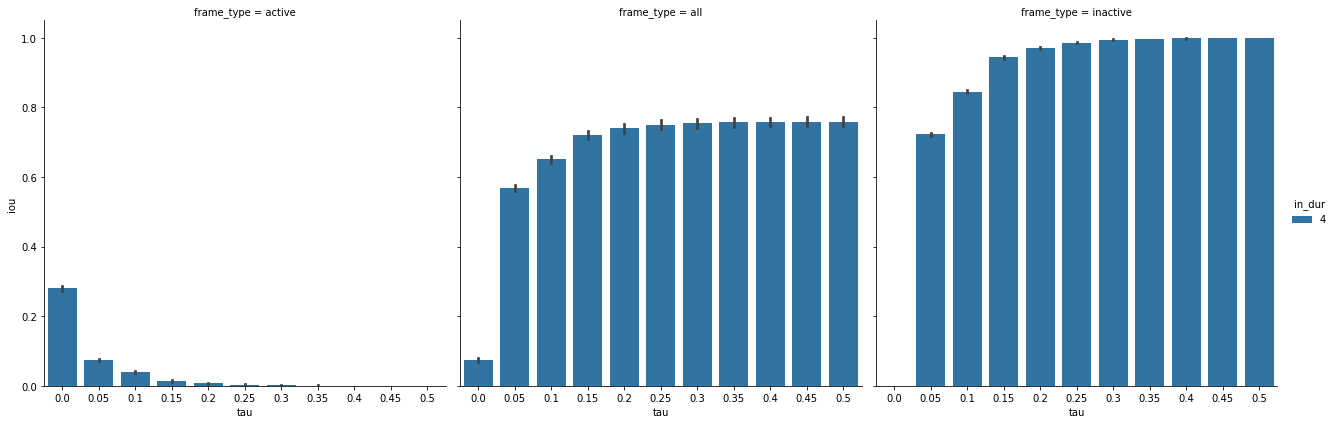

In [149]:
ax = sns.catplot(x='tau', y=score, hue='in_dur', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

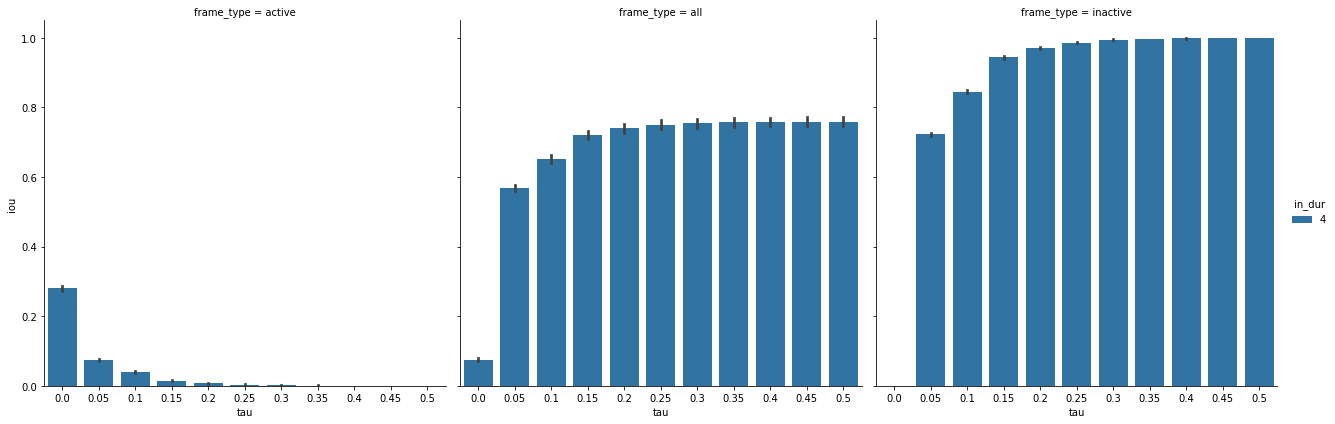

In [150]:
ax = sns.catplot(x='tau', y=score, hue='in_dur', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

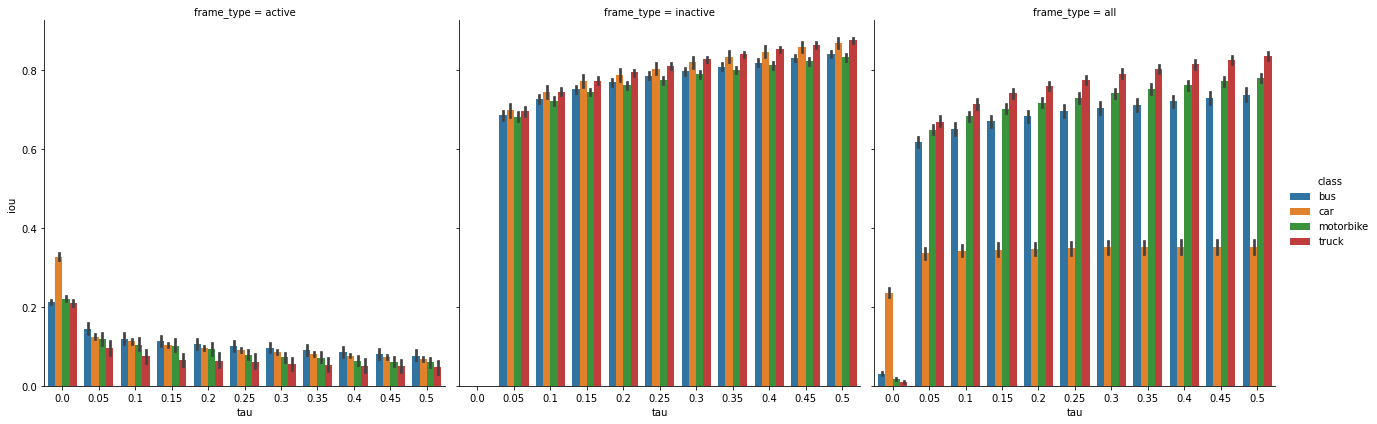

In [17]:
ax = sns.catplot(x='tau', y=score, hue='class', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

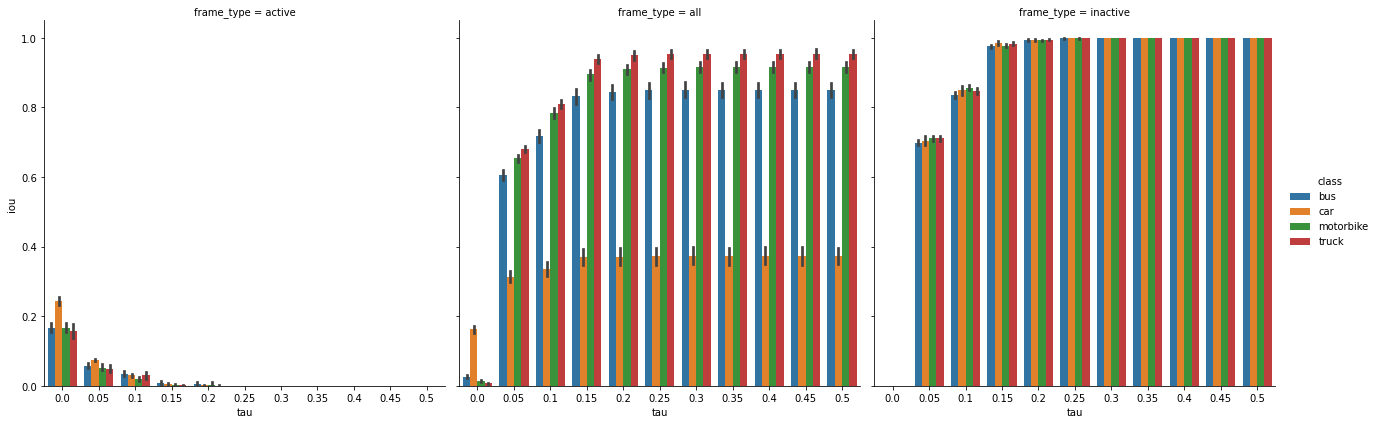

In [81]:
ax = sns.catplot(x='tau', y=score, hue='class', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

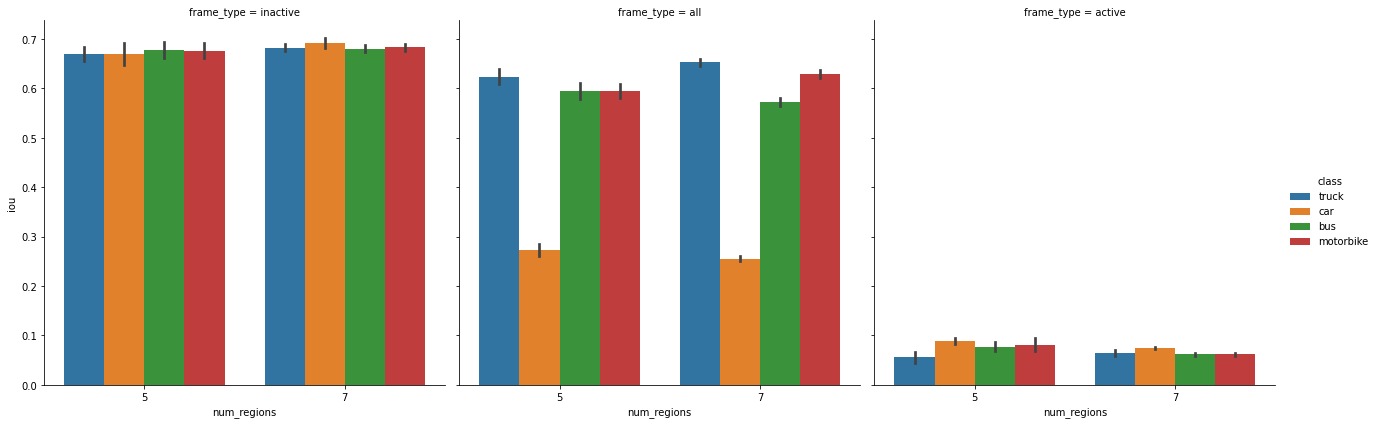

In [10]:
ax = sns.catplot(x='num_regions', y=score, hue='class', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

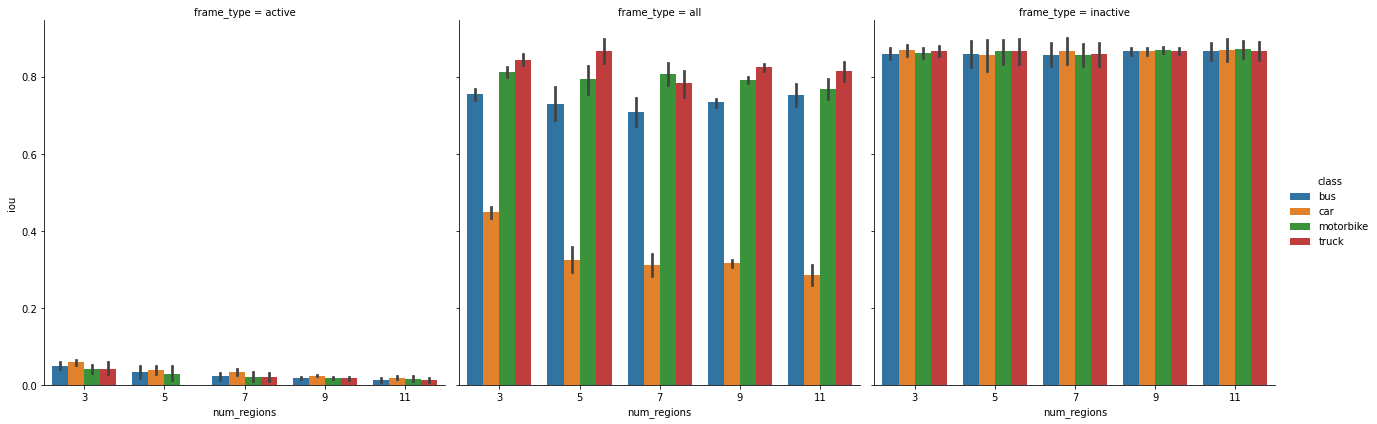

In [82]:
ax = sns.catplot(x='num_regions', y=score, hue='class', data=melted_scores, col='frame_type',
                 kind="bar", height=6, aspect=1)

'Active frames only'

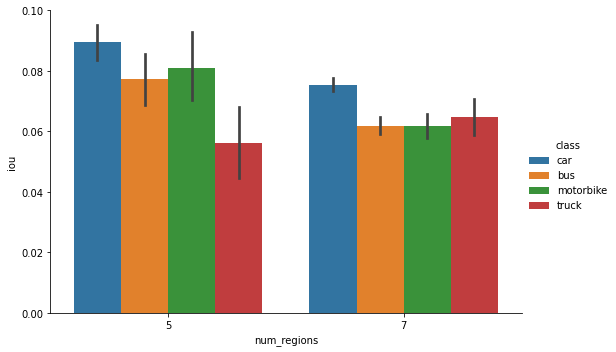

In [11]:
ax = sns.catplot(x='num_regions', y=score, hue='class', data=melted_scores[melted_scores.frame_type=='active'], kind="bar", height=5, aspect=1.5)
'Active frames only'

Text(0.5, 1.0, 'Active frames only')

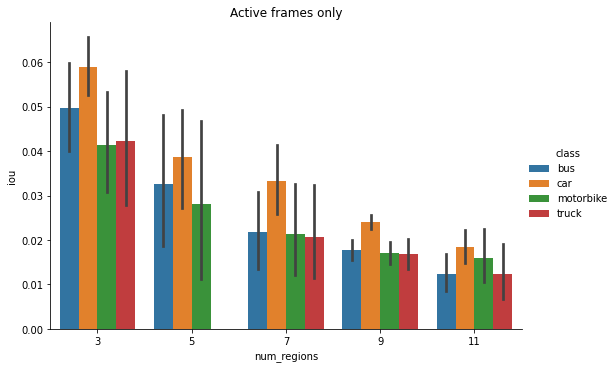

In [132]:
ax = sns.catplot(x='num_regions', y=score, hue='class', data=melted_scores[melted_scores.frame_type=='active'], kind="bar", height=5, aspect=1.5)
'Active frames only'

In [122]:
melted_scores.groupby(['frame_type', 'tau', 'class', 'num_regions']).mean().reset_index()

,frame_type,tau,class,num_regions,uid,iou
0,active,0.0,bus,3,505.303867,0.340833
1,active,0.0,bus,5,503.214286,0.211429
2,active,0.0,bus,7,498.750000,0.149286
3,active,0.0,bus,9,563.868750,0.116979
4,active,0.0,bus,11,522.350877,0.091515
...,...,...,...,...,...,...
655,inactive,0.5,truck,3,505.303867,1.000000
656,inactive,0.5,truck,5,503.214286,1.000000
657,inactive,0.5,truck,7,498.750000,1.000000
658,inactive,0.5,truck,9,563.868750,1.000000


In [86]:
len(set(res['uid']))

782

In [88]:
res_active = res[res['frame_type']=='active']
len(res_active)

17204

In [119]:
res_active[res_active['uid']==1011]

,bus,car,motorbike,truck,score,tau,frame_type,uid,model
2,NaN,0.377778,NaN,NaN,iou,0.00,active,1011,"predictions/train_model,num_regions-3,batch_si..."
3,NaN,0.377778,NaN,NaN,giou,0.00,active,1011,"predictions/train_model,num_regions-3,batch_si..."
8,NaN,0.111111,NaN,NaN,iou,0.05,active,1011,"predictions/train_model,num_regions-3,batch_si..."
9,NaN,0.088889,NaN,NaN,giou,0.05,active,1011,"predictions/train_model,num_regions-3,batch_si..."
14,NaN,0.088889,NaN,NaN,iou,0.10,active,1011,"predictions/train_model,num_regions-3,batch_si..."
15,NaN,0.088889,NaN,NaN,giou,0.10,active,1011,"predictions/train_model,num_regions-3,batch_si..."
20,NaN,0.100000,NaN,NaN,iou,0.15,active,1011,"predictions/train_model,num_regions-3,batch_si..."
21,NaN,0.100000,NaN,NaN,giou,0.15,active,1011,"predictions/train_model,num_regions-3,batch_si..."
26,NaN,0.000000,NaN,NaN,iou,0.20,active,1011,"predictions/train_model,num_regions-3,batch_si..."
27,NaN,0.000000,NaN,NaN,giou,0.20,active,1011,"predictions/train_model,num_regions-3,batch_si..."


In [135]:
uid_list = [1,2, 3]
for i in range(10):
    uid = uid_list[i % len(uid_list)]; i += 1
    print(uid)

1
2
3
1
2
3
1
2
3
1


In [21]:
pred = {}
pred['3'] = {'1':[1], '2':[2]}

In [27]:
df = pd.DataFrame(pred).transpose()
df

,1,2
3,[1],[2]


In [28]:
df['3']

KeyError: '3'